In [ ]:
import os, sys
import numpy as np

# make sure the 'code' dir is on your path (change this):
codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import matplotlib.pyplot as plt
from matplotlib import cm

import copy
import scipy.stats

from plotting import plot_utils, load_fits, summary_plots
from utils import roi_utils, default_paths
from analyze_features import load_feature_stats

plot_utils.set_all_font_sizes(16)

#### Load everything to plot
Here i am loading the results of an analysis correlating each voxel's beta weights with semantic categories (no encoding model used here, just raw data)

In [21]:
subjects = np.arange(1,9)

n_subjects = len(subjects)

feature_type_list_long = ['semantic_discrim_raw_val_all']
feature_type_list = ['raw']
n_models = len(feature_type_list)

# getting info on the names of semantic categories
# choosing to negate one axis to make the plots more intuitive (?)
# but the signs are arbitrary
which_axes_negate = [1,2]
axes_to_do_partial = [0,2,3]
discrim_names, signed_names, n_levels = \
    load_feature_stats.load_partial_discrim_names(axes_to_do_partial, which_axes_negate)

n_discrim_types = len(signed_names);

# diff subjects will have diff numbers of voxels
max_voxels = 30000

partial_corrs = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))
full_corrs = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))

tvals = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))
pvals = np.zeros((n_models, n_discrim_types, n_subjects, max_voxels))

noise_ceilings = np.zeros((n_subjects, max_voxels))

n_voxels_each_subj = np.zeros((n_subjects,),dtype=int)

min_samp=3;

for si, ss in enumerate(subjects):
    
    for fi, fitting_type in enumerate(feature_type_list_long):

        # load the semantic selectivity results for each voxel
        out= load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False);
        assert(out['average_image_reps']==True)
        
        if fi==0:
            n_voxels = int(np.sum(out['voxel_mask']))
            n_voxels_each_subj[si] = n_voxels

        c_partial = copy.deepcopy(out['sem_partial_corrs']).T        
        assert(np.all(out['sem_partial_n_samp']>=min_samp))
        c_partial[which_axes_negate,:] *= (-1)
        partial_corrs[fi,:,si,0:n_voxels] = c_partial;
       
        c_full = copy.deepcopy(out['sem_corr_each_axis'])[:,out['axes_to_do']].T
        c_full[which_axes_negate,:] *= (-1)
        full_corrs[fi,:,si,0:n_voxels] = c_full;
        
        t = copy.deepcopy(out['sem_discrim_each_axis'])[:,out['axes_to_do']].T
        t[which_axes_negate,:] *= (-1)
        tvals[fi,:,si,0:n_voxels] = t;
        
        # compute the p-value for each t-statistic, based on the degrees of freedom
        # (number of samples)
        nsamp = out['n_sem_samp_each_axis'][:,out['axes_to_do'],:]
        df = nsamp[:,:,0]+nsamp[:,:,1]-2
        # two-tailed test, multiply by 2
        p = scipy.stats.t.sf(np.abs(t), df.T)*2
        
        pvals[fi,:,si,0:n_voxels] = p;
        
        noise_ceilings[si,0:n_voxels] = summary_plots.get_noise_ceiling(out)

In [22]:
signed_names

['outdoor > indoor', 'animate > inanimate', 'small > large']

#### Define ROIs

In [23]:
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

In [24]:
partial_corrs_concat = np.concatenate([partial_corrs[0,:,si,0:n_voxels_each_subj[si]].T \
                                       for si in range(n_subjects)], axis=0)
full_corrs_concat = np.concatenate([full_corrs[0,:,si,0:n_voxels_each_subj[si]].T \
                                       for si in range(n_subjects)], axis=0)
nc_concat = np.concatenate([noise_ceilings[si,0:n_voxels_each_subj[si]] \
                            for si in range(n_subjects)], axis=0)
nc_thresh = 0.01
abv_thresh = nc_concat>nc_thresh

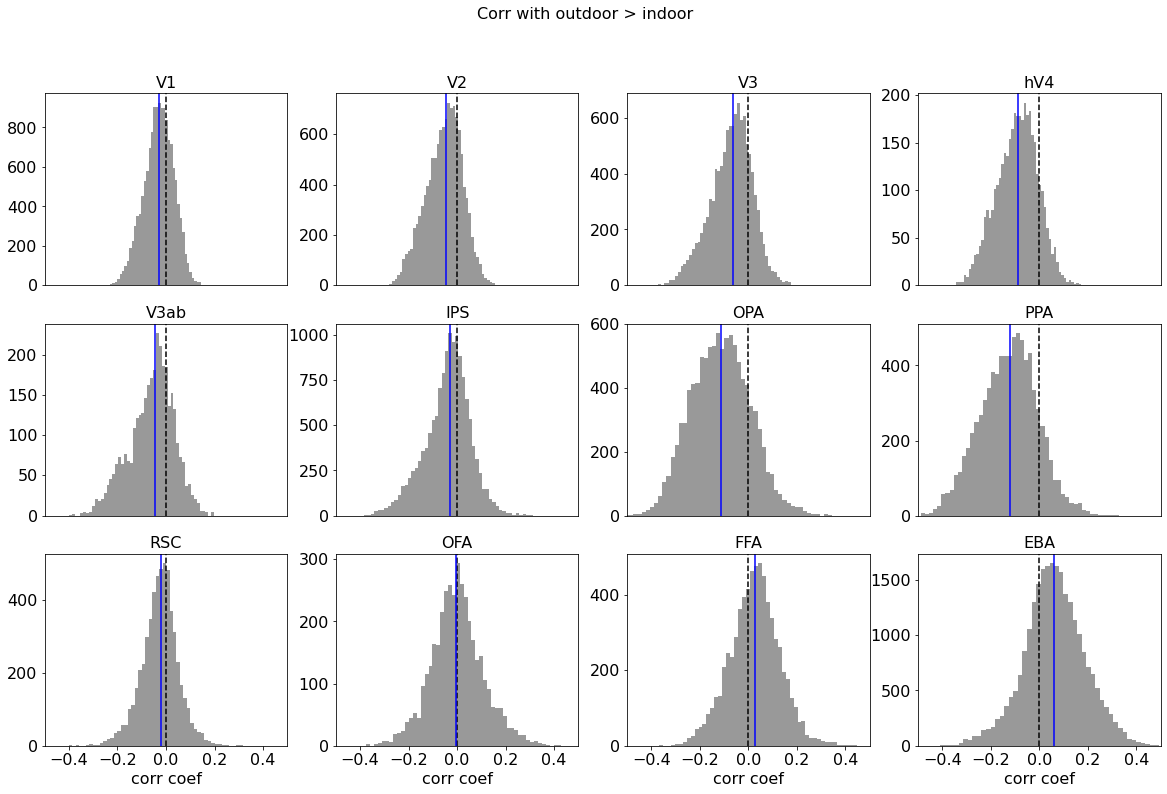

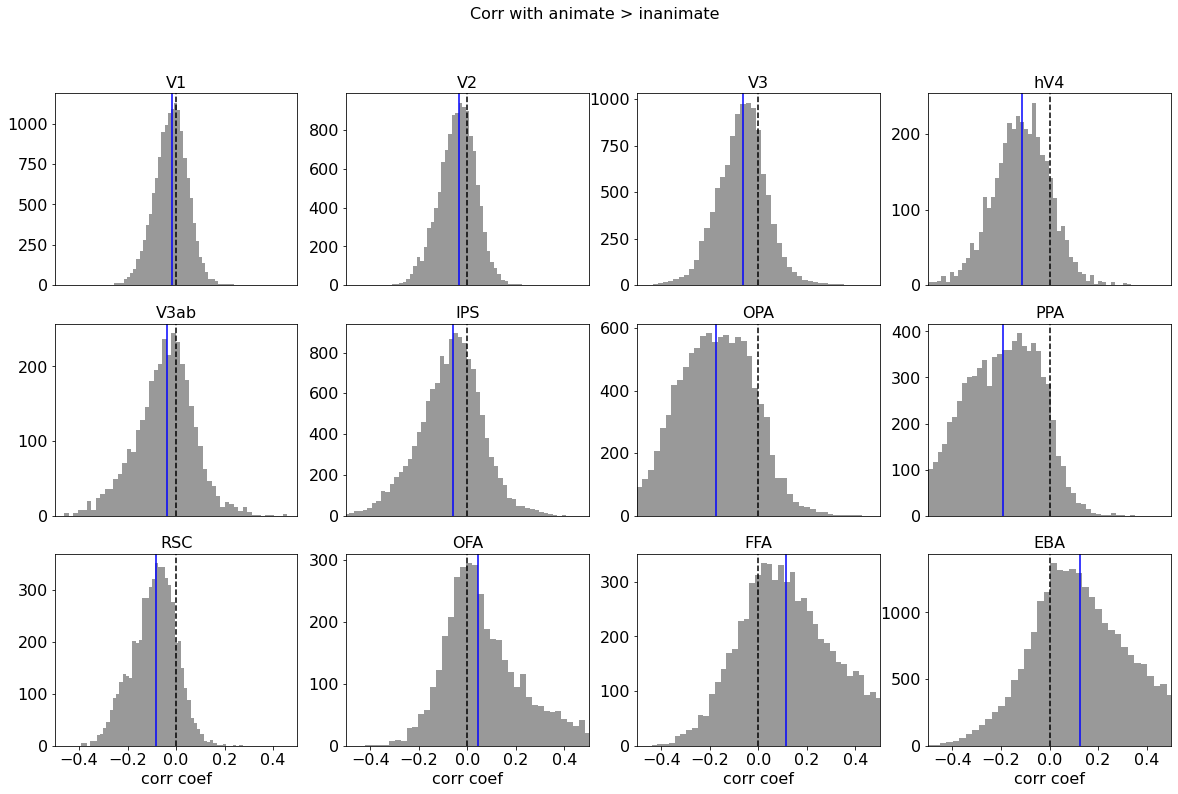

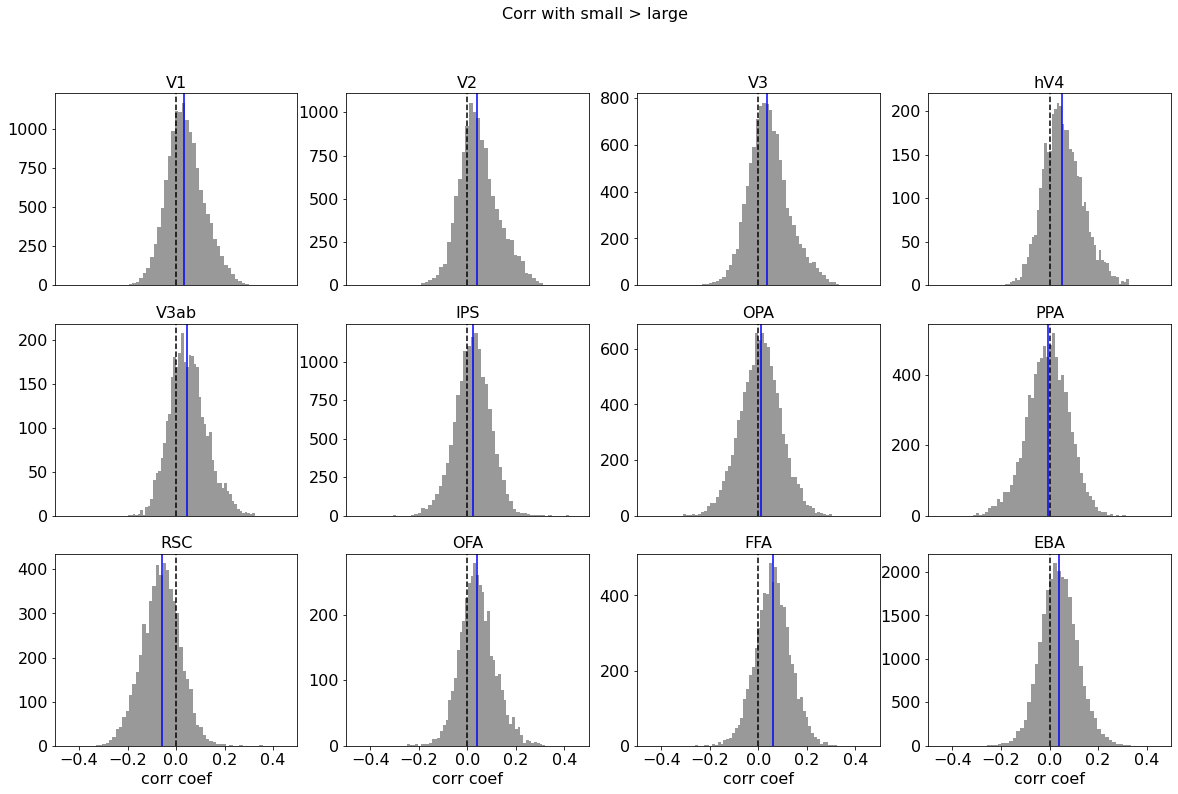

In [28]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for dim in [0,1,2]:

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0

    for rr in range(n_rois):

        pi+=1
        plt.subplot(npx,npy,pi)

        inds_this_roi = roi_def.get_indices(rr)
        inds_this_roi = inds_this_roi & abv_thresh 

        vals = full_corrs_concat[inds_this_roi,dim]

        med = np.median(vals)
        plt.hist(vals, 50, color=[0.6, 0.6, 0.6])
        # plt.xlim([-1.1, 1.1])
        plt.xlim([-0.5, 0.5])
        plt.axvline(0,linestyle='--',color='k')

        plt.title(roi_names[rr])

        plt.axvline(med, color='b')

        if rr>7:
            plt.xlabel('corr coef')
        else:
            plt.xticks([])
            
    plt.suptitle('Corr with %s'%(signed_names[dim]))

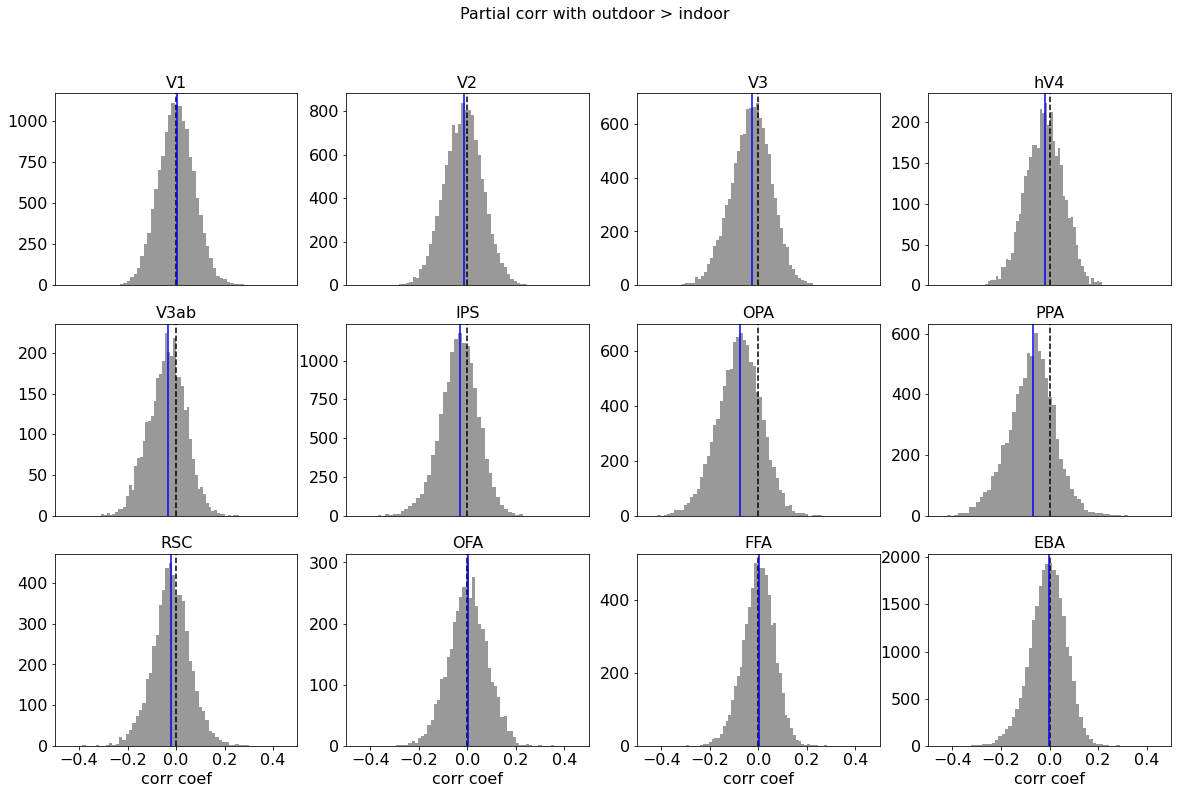

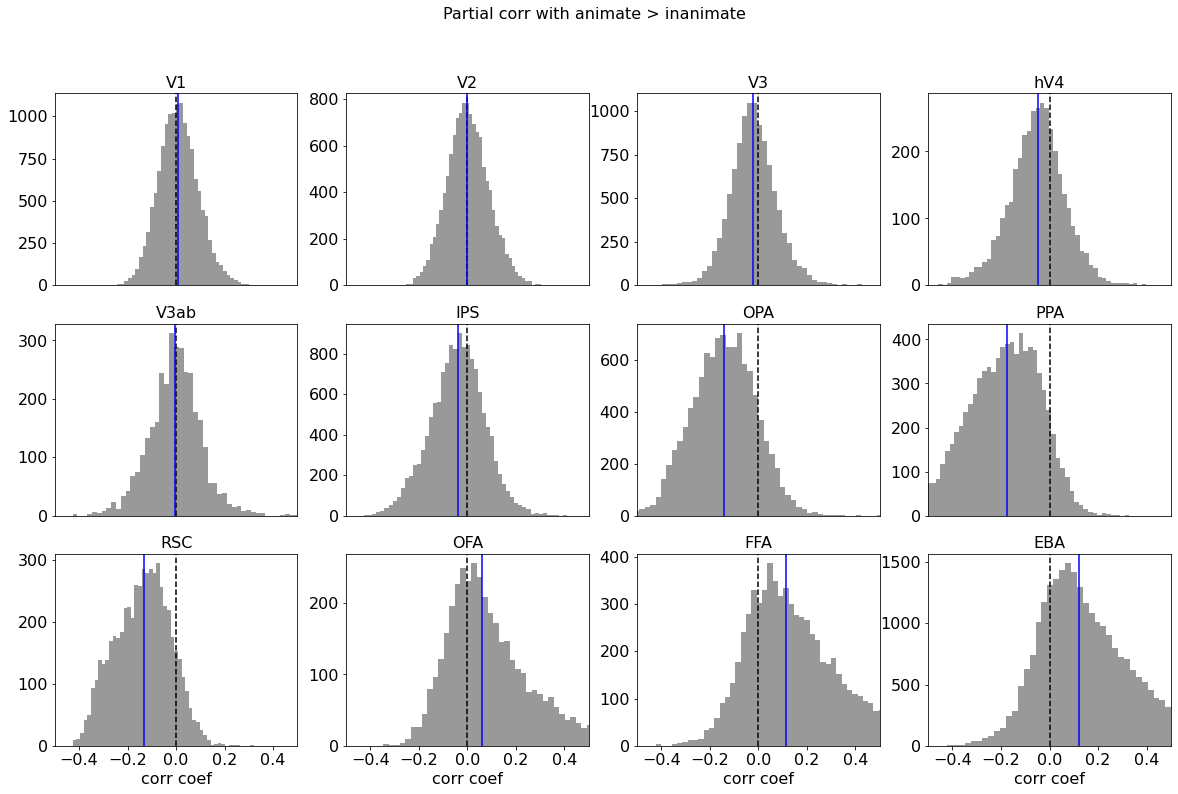

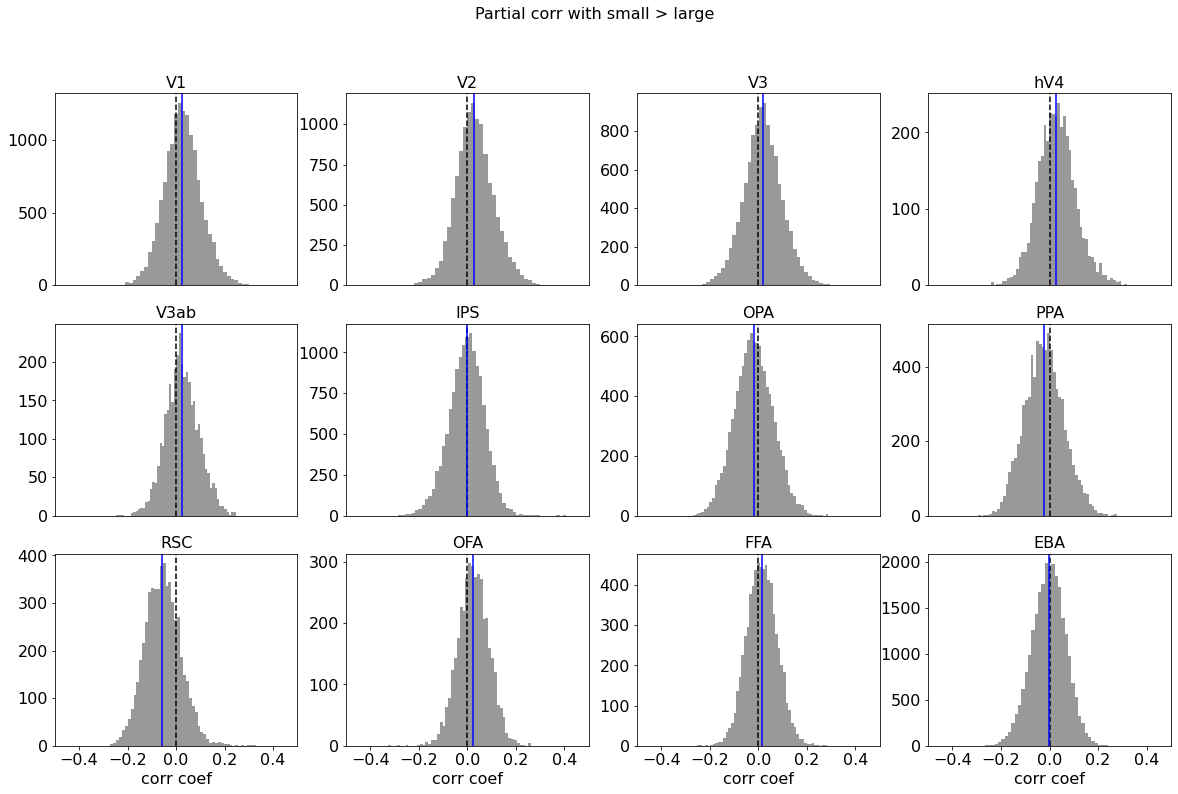

In [27]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for dim in [0,1,2]:

    plt.figure(figsize=(20,12))
    npy = int(np.ceil(np.sqrt(n_rois)))
    npx = int(np.ceil((n_rois)/npy))

    pi=0

    for rr in range(n_rois):

        pi+=1
        plt.subplot(npx,npy,pi)

        inds_this_roi = roi_def.get_indices(rr)
        inds_this_roi = inds_this_roi & abv_thresh 

        vals = partial_corrs_concat[inds_this_roi,dim]

        med = np.median(vals)
        plt.hist(vals, 50, color=[0.6, 0.6, 0.6])
        # plt.xlim([-1.1, 1.1])
        plt.xlim([-0.5, 0.5])
        plt.axvline(0,linestyle='--',color='k')
        
        plt.axvline(med, color='b')

        plt.title(roi_names[rr])

        if rr>7:
            plt.xlabel('corr coef')
        else:
            plt.xticks([])
            
    plt.suptitle('Partial corr with %s'%(signed_names[dim]))

In [5]:
partial_corrs.shape

(1, 3, 8, 30000)

In [8]:
partial_corrs_concat.shape

(150842, 3)

#### Plot the average partial correlation coefficient for each axis
Average over voxels in each ROI, then over subjects

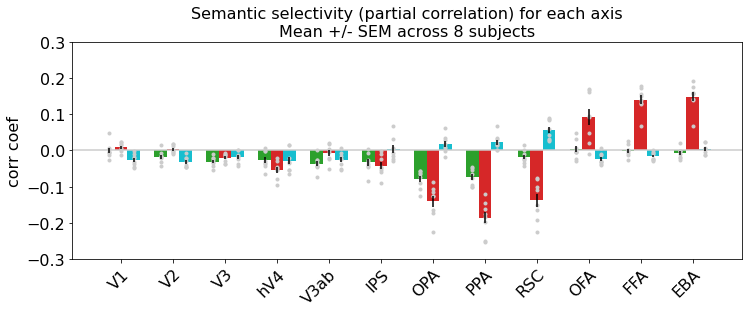

In [10]:
mm=0;

nc_thresh = 0.01

colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

roi_mean_vals = np.zeros((n_rois, 3, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si,0:n_voxels_each_subj[si]]
    vox2use = nc>nc_thresh
    vals = copy.deepcopy(partial_corrs[mm,:,si,0:n_voxels_each_subj[si]])

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42
title='Semantic selectivity (partial correlation) for each axis\nMean +/- SEM across 8 subjects'

bw = 0.24;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = np.moveaxis(roi_mean_vals, [0,1,2], [1,2,0]), \
                                colors=colors, space=space, \
            xticklabels=roi_names, ylabel='corr coef', \
            ylim=[-0.3, 0.3], title=title, horizontal_line_pos=0,\
            legend_labels=signed_names, \
            legend_overlaid=False, legend_separate=False, \
            fig_size=(12,4))

fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
plt.savefig(fn2save)

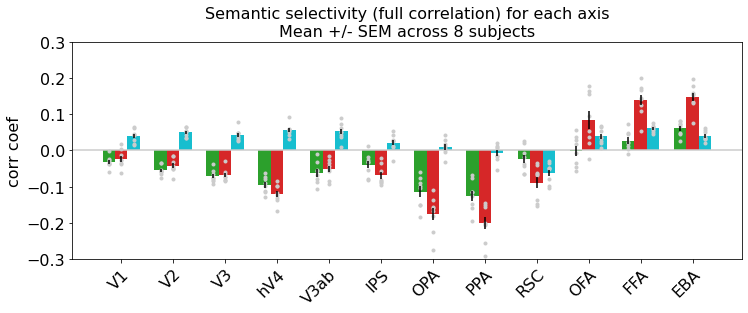

In [6]:
mm=0;

nc_thresh = 0.01

colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

roi_mean_vals = np.zeros((n_rois, 3, n_subjects))

for si in range(n_subjects):

    nc = noise_ceilings[si,0:n_voxels_each_subj[si]]
    vox2use = nc>nc_thresh
    vals = copy.deepcopy(full_corrs[mm,:,si,0:n_voxels_each_subj[si]])

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & vox2use
        roi_mean_vals[ri,:,si] = np.mean(vals[:,inds_this_roi], axis=1)

mean_vals = np.mean(roi_mean_vals, axis=2)
sem_vals = np.std(roi_mean_vals, axis=2)/np.sqrt(n_subjects)

legend_separate = True
plot_utils.set_all_font_sizes(16)

plt.rcParams['pdf.fonttype']=42
title='Semantic selectivity (full correlation) for each axis\nMean +/- SEM across 8 subjects'

bw = 0.24;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data = np.moveaxis(roi_mean_vals, [0,1,2], [1,2,0]), \
                                colors=colors, space=space, \
            xticklabels=roi_names, ylabel='corr coef', \
            ylim=[-0.3, 0.3], title=title, horizontal_line_pos=0,\
            legend_labels=signed_names, \
            legend_overlaid=False, legend_separate=False, \
            fig_size=(12,4))

# fn2save = os.path.join(default_paths.fig_path, 'Semantic_selectivity_signed_ROIavg.pdf')
# plt.savefig(fn2save)

In [5]:
signed_names

['outdoor > indoor', 'animate > inanimate', 'small > large']

In [7]:
from plotting import pycortex_plot_utils

#### Use PyCortex to make surface plots

In [11]:
volumes = {}
out = [load_fits.load_fit_results(ss, fitting_type,n_from_end=0,verbose=False) for ss in subjects]

for si, ss in enumerate(subjects):

    nc = noise_ceilings[si,0:n_voxels_each_subj[si]]
    vox2plot = nc>nc_thresh
    vals_partial = copy.deepcopy(partial_corrs[mm,:,si,0:n_voxels_each_subj[si]])
    vals_full = copy.deepcopy(full_corrs[mm,:,si,0:n_voxels_each_subj[si]])
    vals_tstat = copy.deepcopy(tvals[mm,:,si,0:n_voxels_each_subj[si]])
    vals_mask = copy.deepcopy(pvals[mm,:,si,0:n_voxels_each_subj[si]])<0.01

    names = []
    maps = []
    cmaps = []
    mins = []
    maxes = []
    
    for dim in range(n_discrim_types):
        
        names += ['S%d: %s full'%(ss, signed_names[dim])]
        maps += [vals_full[dim,:]]
        cmaps += ['RdBu']
        mins += [-0.5]
        maxes += [0.5]
                 
    for dim in range(n_discrim_types):
        
        names += ['S%d: %s partial'%(ss, signed_names[dim])]
        maps += [vals_partial[dim,:]]
        cmaps += ['RdBu']
        mins += [-0.5]
        maxes += [0.5]
        
    for dim in range(n_discrim_types):
        
        names += ['S%d: %s t-stat'%(ss, signed_names[dim])]
        maps += [vals_tstat[dim,:]]
        cmaps += ['RdBu']
        mins += [-2]
        maxes += [2]
                 
    for dim in range(n_discrim_types):
        
        names += ['S%d: %s p<0.01'%(ss, signed_names[dim])]
        maps += [vals_mask[dim,:]]
        cmaps += ['RdBu']
        mins += [-0.10]
        maxes += [1.10]
    
   
    voxel_mask = out[si]['voxel_mask']
    nii_shape = out[si]['brain_nii_shape']
    mask_3d = np.reshape(voxel_mask, nii_shape, order='C')

    vol_ss = pycortex_plot_utils.maps_to_volumes(ss, maps, names, \
                         cmaps=cmaps, mins=mins, maxes=maxes, \
                         voxel_mask=voxel_mask, nii_shape=nii_shape, mask_3d=mask_3d, \
                         vox2plot=vox2plot)

    volumes.update(vol_ss)
    

In [12]:
viewer = pycortex_plot_utils.plot_with_overlays(volumes, title='Semantic selectivity partial corrs', \
                                                port = 44443, \
                                                labels_on=False, recache=False, \
                                                overlay_type = 'overlays')

using overlays from /user_data/mmhender/pycortex_db/subj01/overlays.svg
navigate browser to: 127.0.0.1:44443
Started server on port 44443
